# **About the dataset**[<a href="https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia">src</a>]

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

### **Acknowledgements**

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


## **Steps Involved:**
1. Loading and understanding data
2. Data Visualization
3. Data Preprocessing
4. Model Building
5. Model Evaluation
6. Misc

**Reference:**
- Blog- https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8

# **1. Loading and understanding data**

In [3]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import os
!pip install tensorflow
!pip install keras
%matplotlib inline

#pd.set_option("display.max_rows", None,"display.max_columns", None)
warnings.simplefilter(action='ignore')
plt.style.use('seaborn-v0_8')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Before performing any analysis on the dataset lets first read and perform some pre-precessing on the images, so that they are in required format.

**Extracting image path and storing them to a list**

In [5]:
import zipfile

def path_extractor(zipPATH,zip_file,trgt_dir):
  # Extracting content, if "trgt_dir" not present
  if 'chest_xray' not in os.listdir('.'):
    with zipfile.ZipFile(zipPATH+zip_file,"r") as z:
            print(f"Extracting content from {zip_file} ......")
            z.extractall()
            print(f"Extracted to {os.getcwd()}")
  # Storing paths of images in "trgt_dir" to a list
  paths = [] # Stores Image file paths
  cls_labels = [] # Stores Class labels
  print(f"Reading image paths in chest_xray/{trgt_dir} directory")
  folder = "."+os.path.sep+'chest_xray'+os.path.sep+trgt_dir
  print(f'Available classes {os.listdir(folder)}')
  for root, dirs, files in os.walk(folder):
      for file in files:
        if file.endswith(".jpeg"):
          f_path = os.path.join(root, file)
          label = f_path.split('/')[-2]
          cls_labels.append(label)
          paths.append(f_path)
  print("DONE")
  return paths,cls_labels

In [6]:
# Location of zipfile containing dataset
PATH = "/content/drive/MyDrive/Pneumonia_detection/"
zip_file = "archive.zip"

trainImg_paths, y_train = path_extractor(PATH,zip_file,trgt_dir="train")
testImg_paths, y_test = path_extractor(PATH,zip_file,trgt_dir="test")

Reading image paths in chest_xray/train directory
Available classes ['PNEUMONIA', 'NORMAL']
DONE
Reading image paths in chest_xray/test directory
Available classes ['PNEUMONIA', 'NORMAL']
DONE


**Reading images from extracted paths and storing them to an array**

In [7]:
import cv2

IMAGE_SIZE = (150,150)

def images_extractor(paths):
  '''
  Reading images from provided list and returns pre-processed images.
  '''
  images = []
  for path in paths:
    currImg_BGR = cv2.imread(path)
    b,g,r = cv2.split(currImg_BGR)
    currImg_RGB = cv2.merge([r,g,b])
    currImg = cv2.resize(currImg_RGB,IMAGE_SIZE)
    images.append(currImg)
  return images

In [8]:
X_train = images_extractor(trainImg_paths)
X_train = np.array(X_train)
y_train = np.array(y_train)
print("Shape of train set",X_train.shape)
print("Number of train samples",len(X_train))

Shape of train set (5216, 150, 150, 3)
Number of train samples 5216


In [9]:
X_test = images_extractor(testImg_paths)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Shape of test set",X_test.shape)
print("Number of test samples",len(X_test))

Shape of test set (624, 150, 150, 3)
Number of test samples 624


Since data has been extracted and converted to desired format, lets proceed to the next step i.e. data visualization.

# **2. Data Visualization**

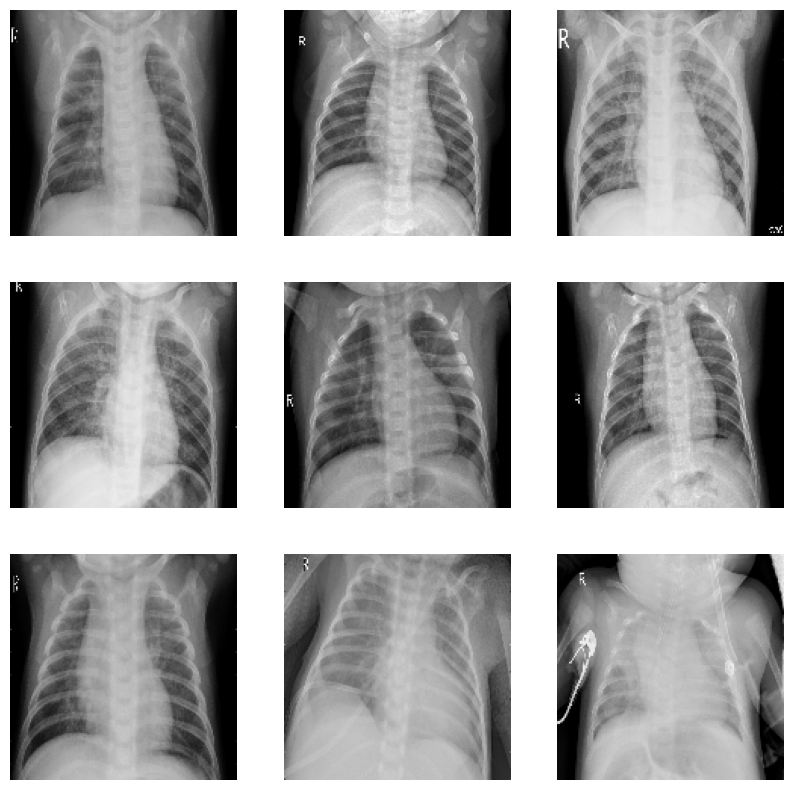

In [10]:
# Visualizing random images from train samples
plt.figure(figsize=(10,10))
for i in range(1,10):
  plt.subplot(3,3,i)
  random_num = np.random.randint(0,len(X_train))
  plt.imshow(X_train[random_num][:,:,:])
  plt.grid(False)
  plt.axis('off')

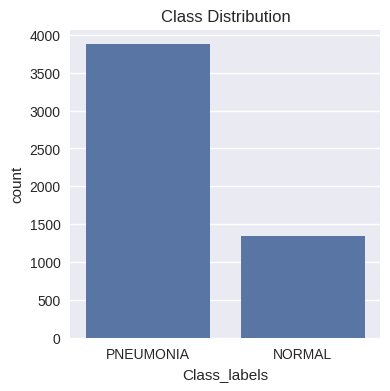

In [11]:
# Checking distribution of classes in train set
y_train_df = pd.DataFrame(y_train,columns=["Class_labels"])
plt.figure(figsize=(4,4))
plt.title("Class Distribution")
sns.countplot(x='Class_labels',data=y_train_df)
plt.show()

# **3. Data Preprocessing**

In [12]:
# for reproducibility
seed = 100
np.random.seed(seed)

## **a) Validation Split**

Seperating small chunk of data for validation, that will be used to validate the model during training phase.

In [13]:
from sklearn.model_selection import train_test_split

valRatio = 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valRatio, random_state=seed)

In [14]:
print("Shape of train set",X_train.shape)
print("Shape of validation set",X_val.shape)
print("Shape of test set",X_test.shape)

Shape of train set (4694, 150, 150, 3)
Shape of validation set (522, 150, 150, 3)
Shape of test set (624, 150, 150, 3)


## **b) Normalization**

The Pixel Values are often stored as Integer Numbers in the range 0 to 255, the range that a single 8-bit byte can offer.


1.    Normalization is performed on the Dataset to Scale the values within a Range. [0,1]
2.    This helps Gradient Descent to Converge much faster.
3.    Normalization is important to bring all the features to equal level and give all of them equal weigthage.
4.    Normalization helps remove distortions caused by Light and Shadows in an Image.

5.    Normalization is carried out as follows:

    x = (x - min) / (max - min) ; Here min=0 and max=255

In [15]:
# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

## **c) Data Augmentation**

Data Augmentation simply means increasing the number of Data points. in terms of Images it means the increasing number of images in the Dataset.

In order to avoid the overfitting problem, we need expand the dataset. This can be acheived by Rotating the Image, Flipping the Image, Zooming the Image, Changing light conditions, Cropping it etc. The more the data, the better our models would perform.

A CNN that can robustly classify objects even if its placed in different orientations is said to have the property called Invariance. In the real world scenario, we may have a dataset of images taken in a limited set of conditions. But, our target application may exist in a variety of conditions, such as different orientation, location, scale, brightness etc. We account for these situations by training our neural network with additional synthetically modified data.

<a href="https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced">Click here</a> to read more about Data Augmentation.


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

## **d) Output label encoding**


In [17]:
y_train[:5]

array(['NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA'],
      dtype='<U9')

In [18]:
pd.get_dummies(y_train,drop_first=True).head()

,PNEUMONIA
0,False
1,True
2,False
3,False
4,True


In [19]:
y_train = pd.get_dummies(y_train,drop_first=True).values
y_val = pd.get_dummies(y_val,drop_first=True).values
y_test = pd.get_dummies(y_test,drop_first=True).values
y_train[:5]

array([[False],
       [ True],
       [False],
       [False],
       [ True]])

# **4. Model Building**

In [20]:
# Loading Deep Learning Libraries
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation, MaxPool2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical

## **a) Building Model Architecture**

In [ ]:
# Defining parameters
input_shape = (150,150,3)
learning_rate = 0.00146
batch_size = 32
epochs = 10

Building a sequential model using a stack of 5 Conv2D-Maxpool2D layers, which is later passed to a stack of fully connected layers to perform final prediction.<a href="https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks">[read more...]</a>
<p style="align:center;"}>
<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/architecture-cnn-en.jpeg?3b7fccd728e29dc619e1bd8022bf71cf">
</p>

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# Displaying model architecture
model.summary()

## **b) Training the model**

**Optimizing the learning rate of optimizer:**

*    Learning Rate plays a vital role in minimizing the Cost Function. Learning Rate is a Descent step which the Optimizing Algorithms take in order to Converge to a local optimum.
*    The Learning rate should be properly tuned , such that it is not too high to take very large steps, neither it should be too small , which would not alter the Weights and Biases.

*    Many Optimization Algorithms have a constant Learning Rate, which many a times do not converge to local optimum, and therefore we need to use Learning Rate such that it starts with a good learning rate and eventually reduces in oder to reach downhill.

*   To implement Learning Rate Decay, we can use either ***LearningRateScheduler*** or ***ReduceLRonPlateau***.
*    ***LearningRateScheduler*** takes the step decay function as argument and return the updated learning rates for use in optimzer at every epoch stage.
*    ***ReduceLRonPlateau*** monitors a quantity and if no improvement is seen for a 'patience' number of epochs, then the learning rate is reduced by a factor specified manually.

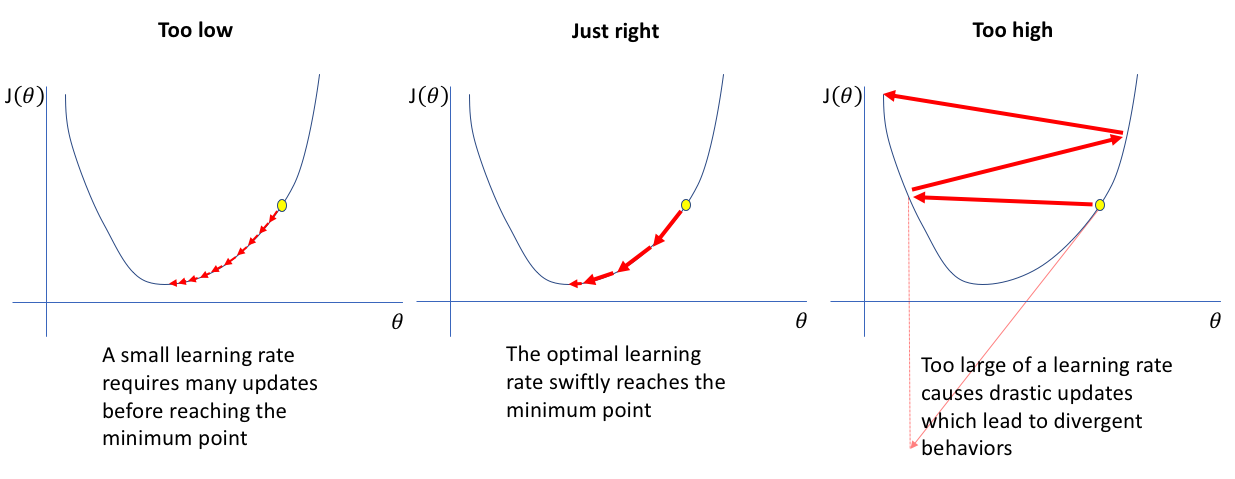

In [23]:
# Initializing callbacks
path = f"/content/drive/MyDrive/Pneumonia_detection/model.h5"

# Saves the model in-between epochs when there is an improvement in "val_loss"
checkpoint = ModelCheckpoint(path,
                                monitor="val_loss",
                                mode="min",
                                save_best_only = True,
                                verbose=1)

# Stops training the model when no improvement in "val_loss" is observed after set "patience"
earlystop = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 4,
                              verbose = 1,
                              restore_best_weights = True)

# Monitors "val_loss" for a set 'patience', then the learning rate is reduced by a factor specified manually.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              patience = 2, verbose=1,
                              factor=0.3, min_lr=0.000001)

callbacks = [checkpoint, earlystop, reduce_lr]

In [24]:
# Training the model for 10 epochs with a batch size of 32(i.e. len(X_train)/batch_size)
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32),
                    epochs = 10, validation_data = datagen.flow(X_val, y_val),
                    callbacks = callbacks)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.7890 - loss: 1.2263
Epoch 1: val_loss improved from inf to 18.81700, saving model to /content/drive/MyDrive/Pneumonia_detection/model.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 53s 278ms/step - accuracy: 0.7892 - loss: 1.2220 - val_accuracy: 0.7644 - val_loss: 18.8170 - learning_rate: 0.0010
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8666 - loss: 0.3294
Epoch 2: val_loss did not improve from 18.81700
147/147 ━━━━━━━━━━━━━━━━━━━━ 62s 200ms/step - accuracy: 0.8667 - loss: 0.3291 - val_accuracy: 0.7644 - val_loss: 29.8512 - learning_rate: 0.0010
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9077 - loss: 0.2510
Epoch 3: val_loss did not improve from 18.81700

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.9077 - loss: 0.2510 - val_accuracy: 0.7644 - val_loss: 30.6443 - learning_rate: 0.0010
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9324 - loss: 0.1756
Epoch 4: val_loss improved from 18.81700 to 1.12612, saving model to /content/drive/MyDrive/Pneumonia_detection/model.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.9325 - loss: 0.1755 - val_accuracy: 0.8525 - val_loss: 1.1261 - learning_rate: 3.0000e-04
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9407 - loss: 0.1696
Epoch 5: val_loss improved from 1.12612 to 0.11628, saving model to /content/drive/MyDrive/Pneumonia_detection/model.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.9408 - loss: 0.1695 - val_accuracy: 0.9579 - val_loss: 0.1163 - learning_rate: 3.0000e-04
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9532 - loss: 0.1353
Epoch 6: val_loss did not improve from 0.11628
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 198ms/step - accuracy: 0.9532 - loss: 0.1353 - val_accuracy: 0.9425 - val_loss: 0.1568 - learning_rate: 3.0000e-04
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9492 - loss: 0.1645
Epoch 7: val_loss did not improve from 0.11628

Epoch 7: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.9492 - loss: 0.1643 - val_accuracy: 0.8391 - val_loss: 0.3648 - learning_rate: 3.0000e-04
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9607 - loss: 0.1165
Epoch 8: val_loss did not improve from 0.11628
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.9607 - loss: 0.1

**Loading the best model**

In [25]:
from keras.models import load_model
# To load model
model = load_model('/content/drive/MyDrive/Pneumonia_detection/model.h5')

# **5. Model Evaluation**

## **a) Plotting train vs validation curves**

In [26]:
def plot_validation_curves(result):
  result = pd.DataFrame(result)
  fig, axs = plt.subplots(1,2)
  result[['loss','val_loss']].plot(figsize=(10, 3),ax=axs[0])
  axs[0].set_title('Train vs validation Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  result[['accuracy','val_accuracy']].plot(figsize=(10, 3),ax=axs[1])
  axs[1].set_title('Train vs validation Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

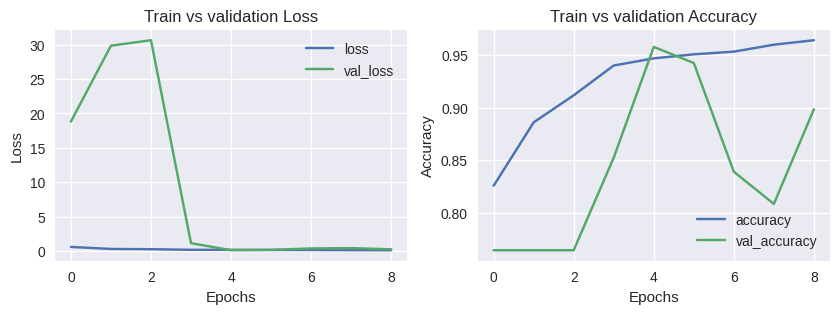

In [27]:
plot_validation_curves(history.history)

## **b) Evaluating model on Test data**

In [28]:
# Performing predictions on test data
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int).reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [29]:
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import numpy as np # Import numpy

def plot_summary(predictions):
  '''
  Plots confustion matrix and classification report.
  '''
  # Selecting class based on higher probabilities
  y_pred_classes = predictions
  # y_test is already one-hot encoded and is a numpy array of booleans.
  # We just need to flatten it for the classification report and confusion matrix.
  y_test_encoded = y_test.flatten().astype(int) # Convert boolean to int

  print("***************** CLASSIFICATION REPORT *****************")
  print(classification_report(y_test_encoded,y_pred_classes),"\n\n")
  print("******************* CONFUSION MATRIX *******************")
  plt.figure(figsize=(8,8))
  sns.heatmap(confusion_matrix(y_test_encoded,y_pred_classes),linewidths=.5,cmap="YlGnBu",annot=True,cbar=False,fmt='d')
  plt.show()

In [30]:
print(y_test.shape)
print(y_test[:5])

(624, 1)
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]]


***************** CLASSIFICATION REPORT *****************
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       234
           1       0.93      0.93      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624
 


******************* CONFUSION MATRIX *******************


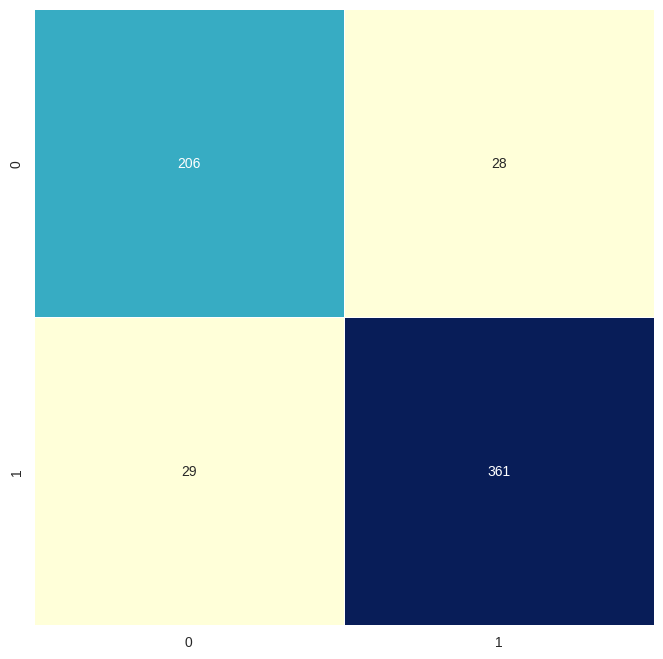

In [31]:
plot_summary(predictions)

**1 : Pneumonia** <br>
**0 : Normal**

# **6. Misc-Saving model architecture to an image**

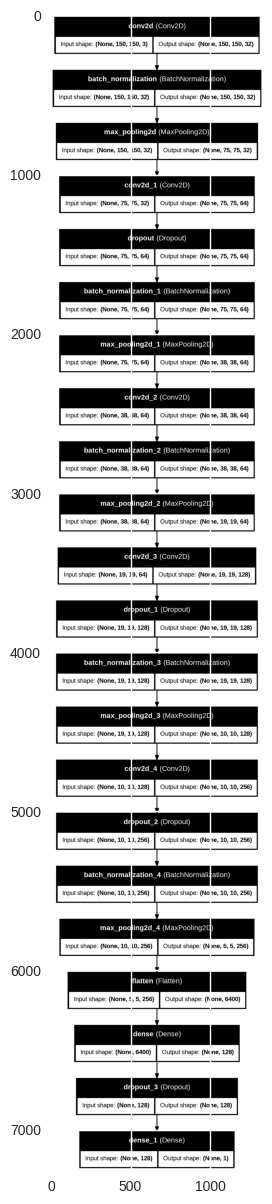

In [32]:
from keras.utils import plot_model

# Save our model diagrams to this path
model_diagrams_path = '/content/drive/MyDrive/Pneumonia_detection/'

# Generate the plot
plot_model(model, to_file = model_diagrams_path + 'model_plot.png',
           show_shapes = True,
           show_layer_names = True)

# Show the plot here
img = plt.imread(model_diagrams_path + 'model_plot.png')
plt.figure(figsize=(30,15))
imgplot = plt.imshow(img)

In [33]:
# Convert y_test to numerical labels (0 or 1)
y_test_encoded = y_test.flatten().astype(int)

In [34]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2896
Test Accuracy: 0.9087
